# Oil Field Decision Problem

This notebook delves into the decision-making process for an oil company evaluating the purchase of an oil field. We will leverage two powerful frameworks: 
* [Decision trees](https://en.wikipedia.org/wiki/Decision_tree) (do not confuse with [classification trees](https://en.wikipedia.org/wiki/Decision_tree_learning)).
* [Influence diagrams](https://en.wikipedia.org/wiki/Influence_diagram).

#### Table of contents:

1. Framing the decision problem

2. Quantifying the decision problem

3. Modeling the problem with a decision tree

4. LLMs' attempt at solving the problem

5. Influence diagrams

6. Modeling the problem with an influence diagram

7. Solving the influence diagram

8. The Future: LLMs and influence diagrams


<div style="border:1px solid #2196F3; padding: 10px; background-color: #E3F2FD; color: #2196F3;">
  <p><strong>Fun fact:</strong> As far as I know, very few people in the world are interested on this topic as of now. A diverse team of researchers is exploring causal influence diagrams, but their primary focus is on AI safety.</p>
</div>


<table>
<tr>
  <td>
    <img src="./images_1/causal_incentives_group.png" alt="Causal Incentives Group" width="600">
  </td>
</tr>
</table>

## 0 - Introduction

**Decision Trees:**

* We will begin by constructing a decision tree to analyze potential outcomes and guide the company towards the most profitable choice.
* Through the decision tree, we will assess factors like oil field quality, geological test results, and potential uncertainties.
* By assigning monetary values (utilities) to each scenario, we will quantify potential profits and estimate probabilities of various outcomes.
* Ultimately, we will use these calculations to identify the decision sequence that maximizes the expected profit for the oil company.

**Influence Diagrams with [PyAgrum](https://pyagrum.readthedocs.io/en/0.16.1/):**

* Next, we will explore how to model the same problem using an influence diagram with the PyAgrum package.
    * Influence diagrams offer a more visually intuitive representation of decision problems, explicitly depicting relationships between variables.
* By comparing the decision tree and influence diagram approaches, we will gain a deeper understanding of their strengths and limitations for this specific problem.

**Future Developments: Integrating Large Language Models (LangChain):**

* As a potential future development, we will briefly discuss how Large Language Models (LLMs) could be integrated into the decision process using LangChain.
    * LLMs have the potential to automate tasks like data analysis and information retrieval, potentially enhancing the efficiency of the decision-making process.

## 1 - Framing the decision problem

An oil company is considering the <span style="color: red"><b>decision</b></span> (<span style="color: red"><b>B</b></span>) to buy an oil field. The oil field can have three quality levels (<span style="color: purple"><b>Q</b></span>): high ($q_1$), medium ($q_2$), and low ($q_3$). The company obviously does not know the "real" qaulity of the field beforehand, but it can provide an estimation (i.e., <span style="color: purple"><b>uncertainty</b></span> ) using historical data and imagery. **It is willing to pay a higher price for the field as its quality increases**.

Before making the buy decision, the company needs to <span style="color: red"><b>decide</b></span> (<span style="color: red"><b>T</b></span>) if it wants to perform a geological test. This test will have a certain cost and its results (<span style="color: purple"><b>R</b></span>) will not be exact predictions about the quality of the field, but will provide a report on the porosity of the reservoir (high porosity generally indicates greater oil potential). The test will not be infallible, and thus contain a certain degree of <span style="color: purple"><b>uncertainty</b></span>. The test can have two possible outcomes:

* **Pass:** The porosity of the reservoir rock is equal to or greater than 15%, indicating significant oil potential.
* **Fail:** The porosity of the reservoir rock is less than 15%, indicating low oil potential.

<table>
<tr>
  <td>
    <img src="./images_1/rock_porosity.jpg" alt="Rock Porosity examples" width="600">
  </td>
</tr>
<tr>
<i><b>Figure 1.</b> Hydrocarbon reservoir quality in terms of permeability and porosity </i>
</tr>
</table>

The chronological sequence of the decision process is as follows:

1. The company decides whether or not to perform the geological test.
2. If the test is performed, the results are observed.
3. The company decides whether or not to buy the oil field.

There is still residual uncertainty in the problem that affects utility: <span style="color: purple"><b>What is the actual state of the oil field?</b></span>

In this example, it seems logical for the company to buy the oil field after obtaining a "pass" result, but this is not always the case. It will depend on its specific a priori beliefs about the quality of the land (for example, based on its historical data on oil fields with similar characteristics), the intrinsic uncertainty of the test (for example, the test may give a positive result but the field is not actually suitable, or vice versa) and how the company values the possible consequences.

## 2 - Quantifying the decision problem

In this case, the quantitative information will be specified explicitly to illustrate these ideas. 

### 2.1 - The utility table (<span style="color: blue">U</span>)

To evaluate the decision tree for the oil field, we need to define the value (utility) of each outcome. This utility reflects the desirability of a particular scenario (buying the field after a successful test, etc.).

There are several ways to define utilities, and the best approach depends on the situation. Here's how we'll approach it:

* **Monetary Values:** We'll primarily focus on the net profit (revenue minus costs) associated with each outcome. This makes sense because the oil company is likely driven by profitability.
* **Potential Adjustments:** We might consider incorporating non-monetary factors like environmental impact in the future. For example, buying a low-quality field might have a lower environmental impact (less drilling required) compared to a high-quality one. We could then adjust the utilities to reflect this.

After several discussions, these are the resulting utilities of the problem:

<table>
  <tr>
    <th><span style="color: red">T</span></th>
    <th><span style="color: red">B</span></th>
    <th><span style="color: purple">Q</span></th>
    <th><span style="color: blue">U</span></th>
  </tr>
  <tr>
    <td rowspan="6">do</td>
    <td rowspan="3">buy</td>
    <td>high</td>
    <td>0.85</td>
  </tr>
  <tr>
    <td>medium</td>
    <td>0.43</td>
  </tr>
  <tr>
    <td>low</td>
    <td>0</td>
  </tr>
  <tr>
    <td rowspan="3">not buy</td>
    <td>high</td>
    <td>0.25</td>
  </tr>
  <tr>
    <td>medium</td>
    <td>0.25</td>
  </tr>
  <tr>
    <td>low</td>
    <td>0.25</td>
  </tr>
  <tr>
    <td rowspan="6">not do</td>
    <td rowspan="3">buy</td>
    <td>high</td>
    <td>0.86</td>
  </tr>
  <tr>
    <td>medium</td>
    <td>0.44</td>
  </tr>
  <tr>
    <td>low</td>
    <td>0.01</td>
  </tr>
  <tr>
    <td rowspan="3">not buy</td>
    <td>high</td>
    <td>0.26</td>
  </tr>
  <tr>
    <td>medium</td>
    <td>0.26</td>
  </tr>
  <tr>
    <td>low</td>
    <td>0.26</td>
  </tr>
</table>

### 2.2 - The prior probability distribution of oil field quality (<span style="color: purple">Q</span>)

This table shows the prior probability distribution of the oil field quality, represented by the variable Q. Prior probability refers to the likelihood of encountering each quality level before any observations are made. These probabilities represent the company's belief on the oil field quality. 

<table>
  <tr>
    <th colspan="2"><span style="color: purple">Q</span></th>
  </tr>
  <tr>
    <td>high</td>
    <td>0.3</td>
  </tr>
  <tr>
    <td>medium</td>
    <td>0.4</td>
  </tr>
  <tr>
    <td>low</td>
    <td>0.3</td>
  </tr>
</table>

We can imagine these probabilities were estimated based on historical information from the oil company's past exploration of similar oil fields. For example, the company could have a classification model that predicts the oil field quality by using [satellite imagery and geographical location data](https://www.satimagingcorp.com/applications/energy/exploration/oil-exploration/).

<table>
  <tr>
  <td>
    <img src="./images_1/oil_field_image.jpg" alt="Oil field image" width="400">
  </td>
    <td>
    <img src="./images_1/oil_field_heatmap.jpg" alt="Oil field heatmap" width="400">
  </td>
  </tr>
</table>

### 2.3 - The conditional probability distribution of the porosity test result (<span style="color: purple"><b>R</b></span>)

The results of the porosity test are directly related to the actual quality of the oil field (<span style="color: purple"><b>Q</b></span>). In a perfect scenario, the test would be highly accurate:

* If the oil field is of **high** quality (<span style="color: purple"><b>Q</b></span> = high), the test result would be "pass" (<span style="color: purple"><b>R</b></span> = pass) with a probability close to 1.
* If the oil field is of **low** quality (<span style="color: purple"><b>Q</b></span> = low), the test result would be "pass" with a probability close to 0.
* If the oil field is of **medium** quality (<span style="color: purple"><b>Q</b></span> = medium), the test result could be "pass" or "fail" with an equal probability (0.5).


However, real-world tests are not perfect. The table below introduces these measurement imperfections by showing the conditional probability of each test result <span style="color: purple"><b>R</b></span> (pass or fail) given the actual quality of the oil field.

<table>
  <tr>
    <th><span style="color: purple">R</span></th>
    <th>high</th>
    <th>medium</th>
    <th>low</th>      
  </tr>
  <tr>
    <td>pass</td>
    <td>0.9</td>
    <td>0.65</td>
    <td>0.15</td>      
  </tr>
  <tr>
    <td>fail</td>
    <td>0.1</td>
    <td>0.35</td>
    <td>0.85</td> 
  </tr>
</table>

## 3 - Modeling the problem with a decision tree

A decision tree is a visual tool that maps out different decision points and their consequences. In this case, we'll use it to model the oil field problem, considering:

* **Uncertainties**. Corresponding to the oil field quality and the accuracy of the geological test
* **Decisions**. The company needs to decide on two things: whether to perform the test and, ultimately, whether to buy the field based on the available information.

<table>
<tr>
  <td>
    <img src="./images_1/oil_decision_tree.png" alt="Oil decision tree" width="500">
  </td>
</tr>
<tr>
<i><b>Figure 2.</b> Oil decision tree </i>
</tr>
</table>

It is worth noting that any structural asymmetry is explicitly reflected in the decision tree. For example, the test results will only be obtained if the company decides to perform the test.

### 3.1 - Evaluating the tree to find the optimal policy

In order to evaluate the decision tree we need:
* The marginal probability distribution of <span style="color: purple"><b>R</b></span>.
* The conditional probabilities of <span style="color: purple"><b>Q</b></span> | <span style="color: purple"><b>R</b></span> (rather than <span style="color: purple"><b>R</b></span> | <span style="color: purple"><b>Q</b></span>), which can be estimated using the **Bayes' Theorem**.

$$
\begin{align*}
P(R = \text{pass}) &= P(R = \text{pass} | Q = \text{high}) P(Q = \text{high}) + P(R = \text{pass} | Q = \text{medium}) P(Q=\text{medium}) + P(R = \text{pass} | Q = \text{low}) P(Q=\text{low}) \\
&= 0.9 \times 0.3 + 0.65 \times 0.4 + 0.15 \times 0.3 = 0.575 \\
P(Q = \text{high} | R = \text{pass}) &= \frac{P(R = \text{pass} | Q = \text{high}) P(Q = \text{high})}{P(R = \text{pass})} = \frac{0.9 \times 0.3}{0.575} = 0.47 \\
P(Q = \text{medium} | R = \text{pass}) &= \frac{P(R = \text{pass} | Q = \text{medium}) P(Q = \text{medium})}{P(R = \text{pass})} = \frac{0.65 \times 0.4}{0.575} = 0.452\\
P(Q = \text{low} | R = \text{pass}) &= \frac{P(R = \text{pass} | Q = \text{low}) P(Q = \text{low})}{P(R = \text{pass})} = \frac{0.15 \times 0.3}{0.575} = 0.078
\end{align*}
$$

Anagolously, we would need estimate the conditional probabilities when $R = \text{fail}$:

$$
\begin{align*}
P(R = \text{fail}) &= 1 - P(R = \text{pass}) = 1 - 0.575 = 0.425\\
P(Q = \text{high} | R = \text{fail})  &= 1 - P(Q = \text{high} | R = \text{pass})  = 1 - 0.47 = 0.53\\
P(Q = \text{medium} | R = \text{fail})  &= 1 - P(Q = \text{medium} | R = \text{pass})  = 1 - 0.452 = 0.548\\
P(Q = \text{low} | R = \text{fail})  &= 1 - P(Q = \text{low} | R = \text{pass})  = 1 - 0.078 = 0.922\\
\end{align*}
$$

Once the probabilities have been estimated, we calcualte the expected utility of each decision node. This is done by:

* Multiplying the payoff of each outcome by its probability.
* Summing these products for all possible outcomes under that decision.

The decision with the highest expected value is considered the optimal choice. For example, to estimate the expected utility of buying the oil field if we have done the test and it has been succesful would be:

$$
0.470 \times 0.85 + 0.452 \times 0.43 + 0 = 0.594
$$

Moving backwards, in the decision node <span style="color: red"><b>B</b></span>, as $0.594 > 0.25$, that wold tell us that i that situation it is better to buy than not buying. Then, we keep repeating this process backwards in the tree until we reach the root node, thus obtaining the optimal policy (i.e., the one with the highest expected utility). 

The provided figure (Figure 3) illustrates an evaluated decision tree with payoffs and expected values. It shows that **it is probabilistically more optimal to do the test** (expected utility of $0.448$ ) versus not doing it (expected utility of $0.437$). Then,

* If the test is successful ("pass"), buying the oil field has the highest expected value.
* If the test fails, not buying the oil field is the better option.


<table>
<tr>
  <td>
    <img src="./images_1/evaluated_oil_decision_tree.png" alt="Evaluated oil decision tree" width="500">
  </td>
</tr>
<tr>
<i><b>Figure 3.</b> Evaluated oil decision tree </i>
</tr>
</table>

This evaluation helps the oil company make informed decisions by considering the uncertainties involved and maximizing their expected utility.

## 4 - LLMs' attempt at solving the problem

As an interesting experiment, I tested several SoTA LLMs. Most of these tests were conducted using HuggingChat. The problem was presented in two steps to facilitate intermediate reasoning:

1. An initial step outlining the problem from a qualitative perspective.
2. A second step detailing the problem from a quantitative perspective.

The text provided to the models was identical to the content of this notebook, including a mix of plain text, LaTeX functions, and HTML tables.

Additionally, I provided minimal guidance to the models when they were close to the solution but did not fully arrive at it, by asking for specific clarifications.

### 4.1 - Models

#### [GPT-4o (OpenAI)](https://openai.com/index/hello-gpt-4o/) in chatgpt.com
[The conversation can be found here](https://chatgpt.com/share/d0835944-124c-400b-b099-3df5adfc03ac)
* Successfully solved the problem on the first try using a decision tree.
* Displayed all necessary formulas for manually repeating the process.
* Answers were very precise, suggesting the use of a calculator or a similar tool for mathematical operations.
  * (Either that or a very similar problem was already in its training set).

#### [R-plus (Cohere)](https://huggingface.co/CohereForAI/c4ai-command-r-plus) in HuggingChat
[The conversation can be found here](https://hf.co/chat/r/fbFKB8C)
* Recognized the need for a decision tree but got confused and failed to solve the problem.
* Utilized two tools:
    * Calculator: For estimating the expected utilities of <span style="color: red"><b>T</b></span>.
    * Image generation: The resulting image was not very useful, resembling a distorted knowledge graph.

<table>
<tr>
  <td>
    <img src="./images_1/r_plus_generated_image.webp" alt="Image generated by the R-plus model to help with the decision making process" width="400">
  </td>
</tr>
<tr>
<i><b>Figure 4.</b> Image generated by the R-plus model to help with the decision making process </i>
</tr>
</table>

#### [Llama-3 70B (Meta)](https://huggingface.co/meta-llama/Meta-Llama-3-70B-Instruct) in HuggingChat
[The conversation can be found here](https://hf.co/chat/r/0EUhmuY)
* Provided the correct decision process using a decision tree.
* Did not estimate the marginal probability of R, automatically assigning $P(R = \text{pass}) = 0.538$.
* Returned a slightly incorrect result due to the lack of a calculator.

#### [Zephyr 8x22B (HuggingFace)](https://huggingface.co/HuggingFaceH4/zephyr-orpo-141b-A35b-v0.1) in HuggingChat
[The conversation can be found here](https://hf.co/chat/r/udkSU0n)
* Provided the correct decision process using a decision tree.
* Displayed all necessary formulas for manually repeating the process.
/ Returned a slightly incorrect solution and hallucinated at the end, indicating **possible memorization**. This also suggests the model may not fully understand the problem.

<table>
<tr>
  <td>
    <img src="./images_1/evidence_of_memorization.png" alt="Possible memorization by Zephyr 8x22B" width="400">
  </td>
</tr>
<tr>
<i><b>Figure 5.</b> Possible memorization by Zephyr 8x22B </i>
</tr>
</table>


#### [Mixtral 8x7B (Mistral AI)](https://huggingface.co/NousResearch/Nous-Hermes-2-Mixtral-8x7B-DPO) in HuggingChat
[The conversation can be found here](https://hf.co/chat/r/ZVyhRCB)
* Provided the correct decision process using a decision tree.
* Returned a slightly incorrect result due to the lack of a calculator.
* Prematurely recommended performing the test without estimating the expected utility of doing so, indicating **possible memorization**.

### 4.2 - Thoughts

Reading the outputs of the different models makes me suspect that there might be some leaking, as this problem is an adaptation of a classic decision problem from a book in Spanish. There is a considerable probability that the models have been trained with the text from the book. Another important aspect is the **low complexity of the problem**. 

While more experiments are needed, it is interesting that these models can understand and address such decision problems. This capability could simplify our work, even if the models have not encountered these specific problems before.

Finally, there is right now a conversation about the limitations of LLMs and the potential of combining them with **symbolic approaches**. This hybrid strategy could improve their capabilities for decision making, probabilistic inference, planning, and much more.

In [1]:
from IPython.display import HTML

url_1 = "https://www.youtube.com/embed/PeSNEXKxarU"
url_2 = "https://www.youtube.com/embed/UakqL6Pj9xo"

display(HTML(f'<iframe width="560" height="315" src="{url_1}" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in- picture" allowfullscreen></iframe>'))
display(HTML(f'<iframe width="560" height="315" src="{url_2}" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in- picture" allowfullscreen></iframe>'))

/Users/fernando/Documents/GitHub/influence-diagrams/.venv/lib/python3.10/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## 5 - Influence diagrams

### 5.1 - Limitations of decision trees

* Computational intractability due to combinatorial explosion
* More difficult to interpret as the number of paths increases
* Limited dependence modeling

#### Computational intractability due to combinatorial explosion

The memory required to store the decision tree and the time required to process it both increase exponentially with the number of variables and their possible states, whether they are decision or probabilistic variables. For $n$ variables, each with $k$ possible outcomes, you would have $k^n$ possible combinations of outcomes.
<br>
<div style="border:1px solid #2196F3; padding: 10px; background-color: #E3F2FD; color: #2196F3;">
  <p><strong>Note:</strong> It doesn't matter if we have GPT-4 or GPT-5. If the LLM approaches the problem with a decision tree, it is going to be <b>computationally intractable to solve.</p>
</div>
<br>

Consider our scenario with two binary decision variables and two probabilistic variables, one with two states and another with three. The total number of possible paths would be $2 \times 2 \times 2 \times 3 = 24$.

The order and "meaning" of the variables (i.e., the problem definition) affects the number of decision paths. In our problem, we have 12 possible decision paths. However, we could envision other problems with the same type of variables that would have 24 possible decision paths:

<table>
<tr>
  <td>
    <img src="./images_1/maximum_paths_decision_tree.png" alt="Alternative decision tree with the maximum number of paths given our set of variables" width="700">
  </td>
</tr>
<tr>
<i><b>Figure 2.</b> Alternative decision tree with the maximum number of paths given our set of variables</i>
</tr>
</table>

#### More difficult to interpret as the number of paths increases

As the number of variables increases, the depth of the decision tree also increases, making the tree harder to manage and analyze.

#### Limited dependence modeling

Decision trees struggle to represent complex relationships between variables. Each branch in the tree depicts a single chain of events, neglecting potential interactions or dependencies.

### 5.2 - Advantages of influence diagrams

* Compact representation that avoids combinatorial explosion
* Use conditional independencies to decompose problems
* Efficient inference algorithms

#### Compact representation that avoids combinatorial explosion

Instead of enumerating all possible states and paths explicitly, influence diagrams represent key elements (decisions, uncertainties, objectives) and their dependencies as nodes and arcs. This graphical abstraction focuses on the **essential relationships** and avoids the exponential growth of states, making the problem more manageable.

#### Use conditional independencies to decompose problems

Influence diagrams leverage conditional independencies among variables to **decompose complex decision problems into smaller, more manageable subproblems**. By isolating independent or conditionally independent subproblems, they reduce the effective state space that needs to be considered, facilitating more efficient problem-solving.

This is the same idea that we apply in Bayesian networks to decompose Joint probability distributions using conditional independencies.

<div style="border:1px solid #2196F3; padding: 10px; background-color: #E3F2FD; color: #2196F3;">
  <p><strong>Note:</strong> I am using a Bayesian network example because it is easier for me to explain, but it is the same idea.</p>
</div>
<br>

**Example:** Variables $A$ and $B$ have three states each (A1, A2, A3 and B1, B2, B3), while variables $C$ and $D$ are binary (C0, C1 and D0, D1)

| State of A | State of B | State of C | State of D | Probability     |
|------------|------------|------------|------------|-----------------|
| A1         | B1         | C1         | D1         | P(A1,B1,C1,D1)  |
| A1         | B1         | C1         | D2         | P(A1,B1,C1,D2)  |
| A1         | B1         | C1         | D3         | P(A1,B1,C1,D3)  |
| A1         | B1         | C2         | D1         | P(A1,B1,C2,D1)  |
| A1         | B1         | C2         | D2         | P(A1,B1,C2,D2)  |
| A1         | B1         | C2         | D3         | P(A1,B1,C2,D3)  |
| A1         | B1         | C3         | D1         | P(A1,B1,C3,D1)  |
| A1         | B1         | C3         | D2         | P(A1,B1,C3,D2)  |
| A1         | B1         | C3         | D3         | P(A1,B1,C3,D3)  |
| A1         | B2         | C1         | D1         | P(A1,B2,C1,D1)  |
| A1         | B2         | C1         | D2         | P(A1,B2,C1,D2)  |
| A1         | B2         | C1         | D3         | P(A1,B2,C1,D3)  |
| A1         | B2         | C2         | D1         | P(A1,B2,C2,D1)  |
| A1         | B2         | C2         | D2         | P(A1,B2,C2,D2)  |
| A1         | B2         | C2         | D3         | P(A1,B2,C2,D3)  |
| A1         | B2         | C3         | D1         | P(A1,B2,C3,D1)  |
| A1         | B2         | C3         | D2         | P(A1,B2,C3,D2)  |
| A1         | B2         | C3         | D3         | P(A1,B2,C3,D3)  |
| A2         | B1         | C1         | D1         | P(A2,B1,C1,D1)  |
| A2         | B1         | C1         | D2         | P(A2,B1,C1,D2)  |
| A2         | B1         | C1         | D3         | P(A2,B1,C1,D3)  |
| A2         | B1         | C2         | D1         | P(A2,B1,C2,D1)  |
| A2         | B1         | C2         | D2         | P(A2,B1,C2,D2)  |
| A2         | B1         | C2         | D3         | P(A2,B1,C2,D3)  |
| A2         | B1         | C3         | D1         | P(A2,B1,C3,D1)  |
| A2         | B1         | C3         | D2         | P(A2,B1,C3,D2)  |
| A2         | B1         | C3         | D3         | P(A2,B1,C3,D3)  |
| A2         | B2         | C1         | D1         | P(A2,B2,C1,D1)  |
| A2         | B2         | C1         | D2         | P(A2,B2,C1,D2)  |
| A2         | B2         | C1         | D3         | P(A2,B2,C1,D3)  |
| A2         | B2         | C2         | D1         | P(A2,B2,C2,D1)  |
| A2         | B2         | C2         | D2         | P(A2,B2,C2,D2)  |
| A2         | B2         | C2         | D3         | P(A2,B2,C2,D3)  |
| A2         | B2         | C3         | D1         | P(A2,B2,C3,D1)  |
| A2         | B2         | C3         | D2         | P(A2,B2,C3,D2)  |
| A2         | B2         | C3         | D3         | P(A2,B2,C3,D3)  |



If conditional independencies are present. It does not make sense to have this big of a table, we can use a Bayesian network and decompose the table into smaller ones. With this we go from $2 \times 2 \times 3 \times 3 = 36$ possible outcomes to $2 + 4 + 6 + 9 = 21$.

<table>
<tr>
  <td>
    <img src="./images_1/bayesian_network_example.png" alt="Bayesian network example" width="400">
  </td>
</tr>
</table>

<table>
  <caption>P(A)</caption>
  <thead>
    <tr>
      <th>State of A</th>
      <th>Probability</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>A1</td>
      <td>P(A1)</td>
    </tr>
    <tr>
      <td>A2</td>
      <td>P(A2)</td>
    </tr>
  </tbody>
</table>

<table>
  <caption>P(B | A)</caption>
  <thead>
    <tr>
      <th>State of A</th>
      <th>State of B</th>
      <th>Probability</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>A1</td>
      <td>B1</td>
      <td>P(B1 | A1)</td>
    </tr>
    <tr>
      <td>A1</td>
      <td>B2</td>
      <td>P(B2 | A1)</td>
    </tr>
    <tr>
      <td>A2</td>
      <td>B1</td>
      <td>P(B1 | A2)</td>
    </tr>
    <tr>
      <td>A2</td>
      <td>B2</td>
      <td>P(B2 | A2)</td>
    </tr>
  </tbody>
</table>

<table>
  <caption>P(C | A)</caption>
  <thead>
    <tr>
      <th>State of A</th>
      <th>State of C</th>
      <th>Probability</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>A1</td>
      <td>C1</td>
      <td>P(C1 | A1)</td>
    </tr>
    <tr>
      <td>A1</td>
      <td>C2</td>
      <td>P(C2 | A1)</td>
    </tr>
    <tr>
      <td>A1</td>
      <td>C3</td>
      <td>P(C3 | A1)</td>
    </tr>
    <tr>
      <td>A2</td>
      <td>C1</td>
      <td>P(C1 | A2)</td>
    </tr>
    <tr>
      <td>A2</td>
      <td>C2</td>
      <td>P(C2 | A2)</td>
    </tr>
    <tr>
      <td>A2</td>
      <td>C3</td>
      <td>P(C3 | A2)</td>
    </tr>
  </tbody>
</table>

<table>
  <caption>P(D | C)</caption>
  <thead>
    <tr>
      <th>State of C</th>
      <th>State of D</th>
      <th>Probability</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>C1</td>
      <td>D1</td>
      <td>P(D1 | C1)</td>
    </tr>
    <tr>
      <td>C1</td>
      <td>D2</td>
      <td>P(D2 | C1)</td>
    </tr>
    <tr>
      <td>C1</td>
      <td>D3</td>
      <td>P(D3 | C1)</td>
    </tr>
    <tr>
      <td>C2</td>
      <td>D1</td>
      <td>P(D1 | C2)</td>
    </tr>
    <tr>
      <td>C2</td>
      <td>D2</td>
      <td>P(D2 | C2)</td>
    </tr>
    <tr>
      <td>C2</td>
      <td>D3</td>
      <td>P(D3 | C2)</td>
    </tr>
    <tr>
      <td>C3</td>
      <td>D1</td>
      <td>P(D1 | C3)</td>
    </tr>
    <tr>
      <td>C3</td>
      <td>D2</td>
      <td>P(D2 | C3)</td>
    </tr>
    <tr>
      <td>C3</td>
      <td>D3</td>
      <td>P(D3 | C3)</td>
    </tr>
  </tbody>
</table>


#### Efficient inference algorithms

Algorithms such as [**variable elimination and belief propagation**](https://www2.it.uu.se/edu/course/homepage/aism/st11/Shachter10.pdf) efficiently compute the necessary probabilities and expected values without enumerating all possible states. These algorithms enable the analysis of large and complex decision problems by focusing on key dependencies and conditional independencies.

### 5.3 - Formal definition

<table>
<tr>
  <td>
    <img src="./images_1/what_is_this.jpg" alt="Influence diagrams" width="400">
  </td>
</tr>
</table>

An **influence diagram** (ID), also known as a relevance diagram, decision diagram, or decision network, is a directed acyclic graph (DAG) represented as $G = (N, E)$, where:

**Nodes:**

The set of nodes $N$ is partitioned into three subsets:

* **Decision nodes** ($D$): Represented by squares, these nodes represent points in the model where a decision-maker can choose between alternative courses of action.
* **Chance nodes** ($C$): Represented by circles, these nodes represent uncertain events or states of nature that can influence the outcome of the decision.
* **Value nodes** ($V$): Represented by diamonds, these nodes represent the expected utilities or outcomes associated with the decision choices.

**Edges:**

The set of edges $E$ includes two types of arcs, depending on the type of node they point to:

* **Informational Arcs**. These arcs connect to decision nodes and indicate temporal precedence. In other words, the variable at the origin of the arc represents information that is available and known at the time the decision is made at the destination node.
* **Conditional Arcs**. These arcs connect to value or chance nodes and represent dependencies, either functional or probabilistic, on the values of the parent nodes. They do not imply causality or temporal precedence.

## 6 - Modeling the decision problem with an influence diagram

Modeling takes place at multiple levels. Similar to constructing a decision tree, drawing the influence diagram represents the qualitative description of the problem (structural or graphical level). Next, quantitative information is incorporated (numerical level) to fully specify the diagram.

In addition, to maintain **problem symmetry**, an extra state `no_results` should be added to the variable <span style="color: purple"><b>R</b></span>. This is because **results are only observed if the test is performed**.

### 6.1 - Memory arcs and LIMIDs

Memory arcs connect decision nodes to other decision nodes or chance nodes, indicating that the information at the source node is remembered and used when making the decision at the target node.

The way we handle memory in the model defines two main types of influence diagrams:

* **Traditional Influence Diagrams**. These assume perfect recall. The decision-maker remembers all past decisions and observations. Here, memory arcs are implicit, meaning the diagram's structure itself connects all relevant past decisions to current ones.
* [**Limited Memory Influence Diagrams (LIMIDs)**](https://web.math.ku.dk/~lauritzen/papers/limids.pdf). These models relax the perfect recall assumption and allow for explicit representation of limited memory. Memory arcs in LIMIDs explicitly specify which past decisions and observations are remembered and used for each current decision.

Traditional influence diagrams can become computationally complex to solve, especially for intricate problems. This is why **LIMIDs are often the preferred choice**. Additionally, LIMIDs offer a more realistic portrayal of real-world decision-making. In practice, people don't always have perfect recall of all past experiences. LIMIDs, with their memory arcs, reflect these limitations, leading to a more accurate model.

<table>
<tr>
  <td>
    <img src="./images_1/oil_influence_diagram.png" alt="Introduction of explicit memory arcs" width="700">
  </td>
</tr>
<tr>
<i><b>Figure 3.</b> Oil influence diagram (LIMID) before and after introducing memory arcs.</i>
</tr>
</table>

### 6.2 - Implementation in PyAgrum

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum as grum
import numpy as np
from pyAgrum import InfluenceDiagram

In [3]:
influence_diagram = InfluenceDiagram()

Q = influence_diagram.addChanceNode(grum.LabelizedVariable("Q", "Q", 0).addLabel('high').addLabel('medium').addLabel('low'))
R = influence_diagram.addChanceNode(grum.LabelizedVariable("R", "R", 0).addLabel('pass').addLabel('fail').addLabel('no_results'))
T = influence_diagram.addDecisionNode(grum.LabelizedVariable("T", "T", 0).addLabel('do').addLabel('not_do'))
B = influence_diagram.addDecisionNode(grum.LabelizedVariable("B", "B", 0).addLabel('buy').addLabel('not_buy'))
U = influence_diagram.addUtilityNode(grum.LabelizedVariable("U", "U", 0).addLabel('utility'))

influence_diagram.addArc("T", "R")
influence_diagram.addArc("T", "B") # memory arc
influence_diagram.addArc("T", "U")
influence_diagram.addArc("R", "B")
influence_diagram.addArc("B", "U")
influence_diagram.addArc("Q", "R")
influence_diagram.addArc("Q", "U")

gnb.sideBySide(influence_diagram, captions=["Oil field influence diagram"])

In [4]:
influence_diagram.cpt(Q)[:]=[0.3, 0.4, 0.3]

influence_diagram.cpt(R)[{"Q": "high", "T": "do"}]=[0.9, 0.1, 0.0]
influence_diagram.cpt(R)[{"Q": "high", "T": "not_do"}]=[0.0, 0.0, 1.0]
influence_diagram.cpt(R)[{"Q": "medium", "T": "do"}]=[0.65, 0.35, 0.0]
influence_diagram.cpt(R)[{"Q": "medium", "T": "not_do"}]=[0.0, 0.0, 1.0]
influence_diagram.cpt(R)[{"Q": "low", "T": "do"}]=[0.15, 0.85, 0.0]
influence_diagram.cpt(R)[{"Q": "low", "T": "not_do"}]=[0.0, 0.0, 1.0]

# We can also use np.array for easier assignment
influence_diagram.utility(U)[{"T": "do", "B": "buy"}]=np.array([0.85, 0.43, 0.0])[:, np.newaxis]
influence_diagram.utility(U)[{"T": "do", "B": "not_buy"}]=np.array([0.25, 0.25, 0.25])[:, np.newaxis]
influence_diagram.utility(U)[{"T": "not_do", "B": "buy"}]=np.array([0.86, 0.44, 0.01])[:, np.newaxis]
influence_diagram.utility(U)[{"T": "not_do", "B": "not_buy"}]=np.array([0.26, 0.26, 0.26])[:, np.newaxis]

In [5]:
gnb.showPotential(influence_diagram.cpt(Q))
gnb.showPotential(influence_diagram.cpt(R))
gnb.showPotential(influence_diagram.utility(U))

## 7 - Solving the influence diagram

Once a comprehensive influence diagram is built, we can use inference algorithms to determine the optimal decision strategy that maximizes expected utility, given the uncertainties and dependencies present in the model.

Solving influence diagrams involves a combination of probabilistic inference (as in Bayesian networks) and decision analysis. Common inference and solution techniques for influence diagrams include:

* **Decision Tree Conversion:** Converts the influence diagram into a decision tree, then solves the tree using standard decision analysis techniques.
* **Dynamic Programming:** Decomposes the decision problem into smaller subproblems, solving each one and combining the results to find the optimal policy.
* **Variable Elimination for Influence Diagrams:** Similar to variable elimination in Bayesian networks, but also accounts for decision and utility nodes. This involves computing expected utilities and optimizing decision nodes.
* **Shenoy-Shafer Algorithm:** An extension of the junction tree algorithm used in Bayesian networks, designed specifically to accommodate the additional complexities introduced by decision and utility nodes in influence diagrams.

The Shenoy-Shafer algorithm offers several advantages over other methods:

* Unified treatment of probabilities and utilities.
* Local computation approach.
* Flexibility in variable elimination.
* Modularity.
* Efficiency in handling LIMIDs.
* Reduced computational complexity.

[PyAgrum features an implementation of the Shenoy-Shafer algorithm tailored for LIMIDs through the `ShaferShenoyLIMIDInference` class.](https://pyagrum.readthedocs.io/en/latest/influenceDiagram.html#pyAgrum.ShaferShenoyLIMIDInference)

### 7.1 - Implementation in PyAgrum

In [6]:
inference_engine = gum.ShaferShenoyLIMIDInference(influence_diagram)
inference_engine.makeInference()

print(f"Is the diagram solvable?: {inference_engine.isSolvable()}")

Is the diagram solvable?: True


We can now estimate the optimal decision path:

* The first question for the decision is: "Should I do the test?", and the answer is **Yes**
* The second question is: "What should I do depending on the test result?", and the answer is:
    * If the test passes, buy the oil field
    * If the test fails, do not buy the oil field 

In [7]:
inference_engine.optimalDecision("T")


(pyAgrum.Potential<double>@0x6000002bc8e0) 
  T                |
do       |not_do   |
---------|---------|
 1.0000  | 0.0000  |

In [8]:
inference_engine.optimalDecision("B")

(pyAgrum.Potential<double>@0x60000029c0e0) 
      ||  B                |
R     ||buy      |not_buy  |
------||---------|---------|
pass  || 1.0000  | 0.0000  |
fail  || 0.0000  | 1.0000  |
no_res|| 1.0000  | 0.0000  |

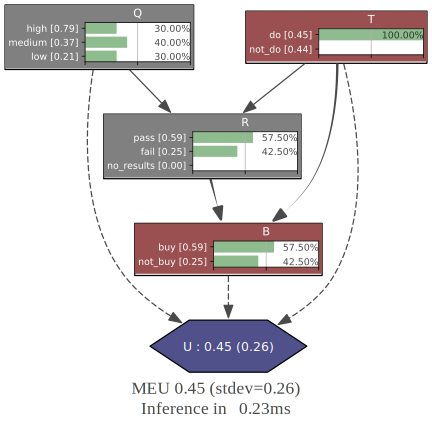

In [9]:
gnb.showInference(influence_diagram,engine=inference_engine,size="6!")

## 8 - The Future: LLMs and influence diagrams

The current capabilities of LLMs in **comprehending decision problems** and **utilizing tools** fuel my optimism integrating them with influence diagrams. I foresee two main steps in this integration process:

1. **Short-term objective:** Using LLMs to input data into an established influence diagram model and format the outputs from the diagram to generate "intelligent" text.

2. **Long-term objective:** Enabling LLMs to analyze problems and automatically generate the appropriate influence diagrams. These diagrams would then be used to solve the problems and format the output accordingly.

From an implementation perspective, there are several ways to integrate LLMs with influence diagrams:

* [Develop custom tools within LangChain to allow seamless interfacing with existing influence diagrams](https://python.langchain.com/v0.1/docs/modules/tools/custom_tools/) . This would enable agents to utilize and interact directly with complex decision models.

* [Leverage the capabilities of PyAgrum to generate influence diagrams from text using the `fastID()` method](https://pyagrum.readthedocs.io/en/latest/fastSyntax.html#pyAgrum.fastID). This could involve training an LLM to create these diagrams either automatically or through guided instructions. The diagrams could then be executed in a "controlled" manner. This would enhance the model reasning capabilities by enabling dynamic creation and utilization of decision models.

* [Utilize the coding capabilities of LLMs to generate and execute Python code](https://python.langchain.com/v0.1/docs/integrations/toolkits/python/). While this approach might be the most powerful, it is also the furthest from current capabilities and would require some form of supervision for security reasons.

In [10]:
gum.fastID('A->B[1,3]<-*C{yes|No}->$D<-E[1,2.5,3.9]',6)

(pyAgrum.InfluenceDiagram<double>@0x145193200) Influence Diagram{
  chance: 3,
  utility: 1,
  decision: 1,
  arcs: 4,
  domainSize: 72
}